In [133]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import model_common
import xrd
import helpers as h
from importlib import reload
reload(model_common)
reload(xrd)
reload(h)

# MODEL_CHECKPOINT = 'checkpoints/dataset_10000_dl100_7d_v3.pt'
MODEL_CHECKPOINT = 'checkpoints/dataset_100000_dl100_7d_v3.pt'

# true_params = [0.028500, 0.023000, 4.000e-05, 1.050e-05, 0.006000, 2.000e-05, -5.000e-06]
# true_params = [0.028500, 0.023000, 4.000e-05, 1.050e-05, 0.006000, 2.000e-05, -5.000e-06]
# from experiment file
true_params = [0.008094, 0.000943, 5200e-8, 3500e-8, 0.00255, 3000e-8, -50e-8]

original_curve, original_profile = xrd.compute_curve_and_profile(
    array=true_params,
    dl=100e-8
)

In [134]:
original_curve.ML_Y

array([4.35107824e-04, 4.41533222e-04, 4.19266275e-04, 3.76309497e-04,
       3.32649766e-04, 3.10541974e-04, 3.22456410e-04, 3.63487507e-04,
       4.12818122e-04, 4.44018355e-04, 4.39168380e-04, 3.99095222e-04,
       3.43673641e-04, 3.01943559e-04, 2.97522218e-04, 3.36720942e-04,
       4.04978638e-04, 4.73254862e-04, 5.11374749e-04, 5.02231984e-04,
       4.50744945e-04, 3.83608437e-04, 3.38999537e-04, 3.49515716e-04,
       4.25644131e-04, 5.48112319e-04, 6.74094226e-04, 7.55846343e-04,
       7.63755519e-04, 7.02455792e-04, 6.11424726e-04, 5.49301769e-04,
       5.69096797e-04, 6.95088523e-04, 9.10868133e-04, 1.16329075e-03,
       1.38117511e-03, 1.50250477e-03, 1.50072639e-03, 1.39975022e-03,
       1.26959436e-03, 1.20168045e-03, 1.27255774e-03, 1.51149984e-03,
       1.88629780e-03, 2.31316679e-03, 2.68592856e-03, 2.91238982e-03,
       2.94505913e-03, 2.79720577e-03, 2.53989890e-03, 2.27998190e-03,
       2.12452453e-03, 2.14356592e-03, 2.34556247e-03, 2.67536524e-03,
      

In [135]:
# input_Y

In [136]:
device = "mps"

# ============================================================================
# ЗАВАНТАЖИТИ МОДЕЛЬ
# ============================================================================
checkpoint = torch.load(MODEL_CHECKPOINT, map_location=device)
print(f"\n✅ Loaded checkpoint from {MODEL_CHECKPOINT}")
print(f"   Epoch: {checkpoint.get('epoch', 'N/A')}, Val loss: {checkpoint.get('val_loss', 'N/A')}")

model = model_common.XRDRegressor().to(device)
model.load_state_dict(checkpoint['model'])
model.eval()

# ============================================================================
# ПІДГОТУВАТИ ДАНІ (точно так само як в model_evaluate.py!)
# ============================================================================
# Створити dummy X (не використовується моделлю)
dummy_X = torch.tensor([0,0,0,0,0,0,0], dtype=torch.float32).unsqueeze(0)  # [1, 7]

# Підготувати криву Y
# input_Y = Y[sample_idx:sample_idx+1]  # [1, L]

# Створити датасет з тими самими параметрами, що й при evaluate
ds = model_common.NormalizedXRDDataset(
    dummy_X, 
    torch.tensor(original_curve.ML_Y).unsqueeze(0),  # [1, L]
    log_space=True,  # ❗ ВАЖЛИВО - має співпадати з model_evaluate.py
    train=False
)

# ============================================================================
# PREDICTION
# ============================================================================
print(f"\n🔮 Running prediction...")
with torch.no_grad():
    y_normalized = ds.Yn[0].unsqueeze(0).to(device, dtype=torch.float32)  # [1, 1, L]
    pred_normalized = model(y_normalized)
    pred_params = model_common.denorm_params(pred_normalized)

predicted_from_dataset = pred_params[0].cpu().numpy()

print(f"\n📊 RESULTS:")
print(f"   True     : {h.fparam(arr=true_params)}")
print(f"   Predicted: {h.fparam(arr=predicted_from_dataset)}")


✅ Loaded checkpoint from checkpoints/dataset_100000_dl100_7d_v3.pt
   Epoch: 69, Val loss: 0.010460084508359432

🔮 Running prediction...

📊 RESULTS:
   True     : Dmax1=0.0081, D01=0.0009, L1=5200 Rp1=3500, D02=0.0026, L2=3000, Rp2=-50
   Predicted: Dmax1=0.0060, D01=0.0015, L1=4998 Rp1=3058, D02=0.0021, L2=2567, Rp2=-1


In [137]:
# Перевірка - виведемо predicted параметри
print("\n📋 DETAILED COMPARISON:")
print(f"{'Parameter':<10} {'True':<15} {'Predicted':<15} {'Error':<15}")
print("-" * 55)
for i, name in enumerate(model_common.PARAM_NAMES):
    true_val = true_params[i]
    pred_val = predicted_from_dataset[i]
    error = pred_val - true_val
    print(f"{name:<10} {true_val:<15.6e} {pred_val:<15.6e} {error:+15.6e}")


📋 DETAILED COMPARISON:
Parameter  True            Predicted       Error          
-------------------------------------------------------
Dmax1      8.094000e-03    6.049936e-03      -2.044064e-03
D01        9.430000e-04    1.463085e-03      +5.200854e-04
L1         5.200000e-05    4.998394e-05      -2.016062e-06
Rp1        3.500000e-05    3.057766e-05      -4.422338e-06
D02        2.550000e-03    2.081756e-03      -4.682441e-04
L2         3.000000e-05    2.566768e-05      -4.332316e-06
Rp2        -5.000000e-07   -6.788468e-09     +4.932115e-07



🎨 Generating full curves for visualization...


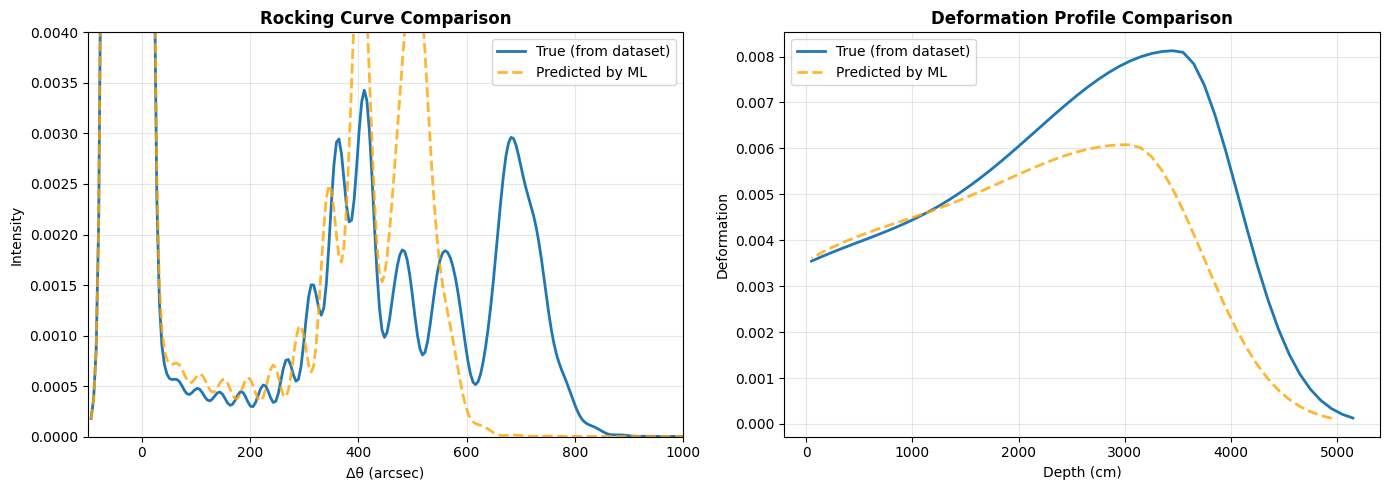


✅ Visualization complete!


In [138]:
import matplotlib.pyplot as plt
import xrd
from importlib import reload
reload(xrd)

# ============================================================================
# ГЕНЕРУВАТИ ПОВНІ КРИВІ ДЛЯ ВІЗУАЛІЗАЦІЇ
# ============================================================================
print("\n🎨 Generating full curves for visualization...")

# True curve (з параметрів з датасету)
true_curve, true_profile = xrd.compute_curve_and_profile(
    array=true_params,
    dl=100e-8
)

# Predicted curve (з predicted параметрів)
predicted_curve, predicted_profile = xrd.compute_curve_and_profile(
    array=predicted_from_dataset.tolist(),
    dl=100e-8
)

# ============================================================================
# ВІЗУАЛІЗАЦІЯ
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rocking Curve
axes[0].set_title("Rocking Curve Comparison", fontsize=12, fontweight='bold')
axes[0].plot(true_curve.X_DeltaTeta, true_curve.Y_R_vseZ, 
             label="True (from dataset)", color='C0', linestyle='-', linewidth=2)
axes[0].plot(predicted_curve.X_DeltaTeta, predicted_curve.Y_R_vseZ, 
             label="Predicted by ML", color='orange', linestyle='--', linewidth=2, alpha=0.8)
axes[0].set_xlabel("Δθ (arcsec)")
axes[0].set_ylabel("Intensity")
axes[0].set_ylim(0, 0.004)
axes[0].set_xlim(-100, 1000)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Deformation Profile
axes[1].set_title("Deformation Profile Comparison", fontsize=12, fontweight='bold')
axes[1].plot(true_profile.X, true_profile.total_Y, 
             label="True (from dataset)", color='C0', linestyle='-', linewidth=2)
axes[1].plot(predicted_profile.X, predicted_profile.total_Y, 
             label="Predicted by ML", color='orange', linestyle='--', linewidth=2, alpha=0.8)
axes[1].set_xlabel("Depth (cm)")
axes[1].set_ylabel("Deformation")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n✅ Visualization complete!")